In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import copy
from sklearn.utils import shuffle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def get_images_list(root_path, list_slides):
  imgs = []
  for list_slide in list_slides:
    imgs.append(load_and_preprocess_image(os.path.join(root_path, list_slide)))
  return imgs

In [ ]:
root_path = "drive/My Drive/Preprocessed_data_ADL/level6"
file_path_train = root_path + "/train"
file_path_test = root_path + "/test"

In [ ]:
train_slides_list = np.sort(os.listdir(file_path_train+"/slides"))
train_masks_list = np.sort(os.listdir(file_path_train+"/masks"))
print(len(train_slides_list))
print(len(train_masks_list))

416
416


In [ ]:
test_slides_list = np.sort(os.listdir(file_path_test+"/slides"))
test_masks_list = np.sort(os.listdir(file_path_test+"/masks"))
print(len(test_slides_list))
print(len(test_masks_list))

136
136


In [ ]:
from sklearn.utils import shuffle
def shuffle_XY(X, Y):
  X, Y = shuffle(X, Y, random_state = 0)
  return X, Y

In [ ]:
train_slides_p, train_masks_m = shuffle_XY(train_slides_list, train_masks_list)

In [ ]:
train_s = get_images_list(file_path_train+"/slides", train_slides_p)

416


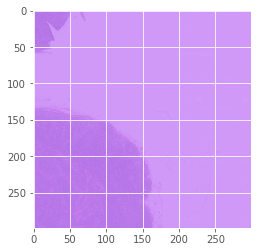

In [ ]:
print(len(train_s))
plt.imshow(train_s[0])

In [ ]:
train_m = get_images_list(file_path_train+"/masks", train_masks_m)

In [ ]:
test_slides_p, test_masks_p = shuffle_XY(test_slides_list, test_masks_list)

In [ ]:
test_s = get_images_list(file_path_test+"/slides", test_slides_p)

In [ ]:
test_m = get_images_list(file_path_test+"/masks", test_masks_p)

In [ ]:
#Experiment 1: U-Net Code
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
im_width = 128
im_height = 128
border = 5
path_train = file_path_train
path_test = file_path_test

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_width, im_height, 1), name='img')
# input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 128, 128, 16) 64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 128, 128, 16) 0           batch_normalization_55[0][0]     
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(os.path.join(file_path_train, 'model-tumor-seg-v1-50-epochs.h5'), verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
x_train_Unet = np.array([resize(x_img, (128, 128, 1), mode='constant', preserve_range=True) for x_img in train_s])
y_train_Unet = np.array([resize(y_img, (128, 128, 1), mode='constant', preserve_range=True) for y_img in train_m])

In [ ]:
x_val_Unet = np.array([resize(x_img, (128, 128, 1), mode='constant', preserve_range=True) for x_img in test_s])
y_val_Unet = np.array([resize(y_img, (128, 128, 1), mode='constant', preserve_range=True) for y_img in test_m])

In [ ]:
print(x_train_Unet.shape)
print(y_train_Unet.shape)

print(x_val_Unet.shape)
print(y_val_Unet.shape)

(416, 128, 128, 1)
(416, 128, 128, 1)
(136, 128, 128, 1)
(136, 128, 128, 1)


In [ ]:
# Model trained for approx 45 epochs on level 7
results = model.fit(x_train_Unet, y_train_Unet, batch_size=32, epochs=5, callbacks=callbacks,
                    validation_data=(x_val_Unet, y_val_Unet))

Train on 88 samples, validate on 40 samples
Epoch 1/5
88/88 [==============================] - 19s 218ms/step - loss: -79.9530 - accuracy: 0.8601 - val_loss: -37.5581 - val_accuracy: 0.8448

Epoch 00001: val_loss did not improve from -5409.07500
Epoch 2/5
88/88 [==============================] - 19s 220ms/step - loss: -77.8252 - accuracy: 0.8528 - val_loss: -34.1860 - val_accuracy: 0.8520

Epoch 00002: val_loss did not improve from -5409.07500
Epoch 3/5
88/88 [==============================] - 19s 219ms/step - loss: -73.1879 - accuracy: 0.8391 - val_loss: -30.9485 - val_accuracy: 0.8584

Epoch 00003: val_loss did not improve from -5409.07500
Epoch 4/5
88/88 [==============================] - 19s 218ms/step - loss: -79.4650 - accuracy: 0.8525 - val_loss: -28.2299 - val_accuracy: 0.8635

Epoch 00004: val_loss did not improve from -5409.07500
Epoch 5/5
88/88 [==============================] - 19s 219ms/step - loss: -79.3408 - accuracy: 0.8574 - val_loss: -26.3473 - val_accuracy: 0.8662

E

(128, 128)


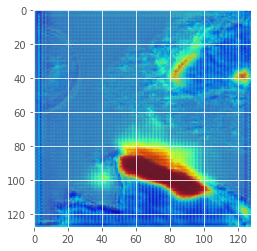

(128, 128)


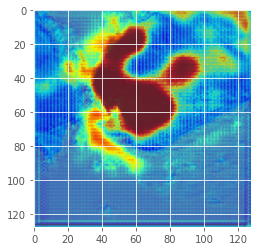

(128, 128)


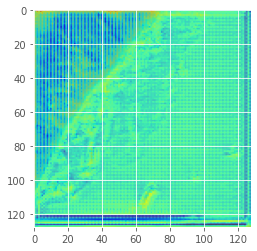

In [ ]:
indices = [8, 9, 10]
for index in indices:
  predictions = model.predict(np.array([x_val_Unet[index]]))
  predictions = tf.squeeze(predictions)
  print(predictions.shape)
  plt.imshow(tf.squeeze(x_val_Unet[index]))
  plt.imshow(predictions, cmap='jet', alpha=0.7)
  plt.show()

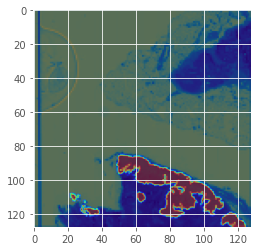

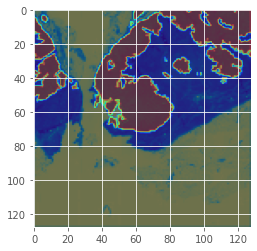

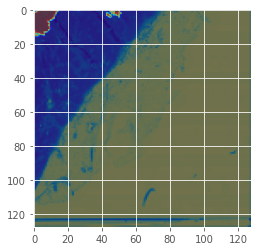

In [ ]:
for index in indices:
  true_label = tf.squeeze(y_val_Unet[index])
  plt.imshow(tf.squeeze(x_val_Unet[index]))
  plt.imshow(true_label, cmap='jet', alpha=0.5)
  plt.show()

In [ ]:
model_path = root_path + "/model_unet_level7_v1.h5"
model.save(model_path)

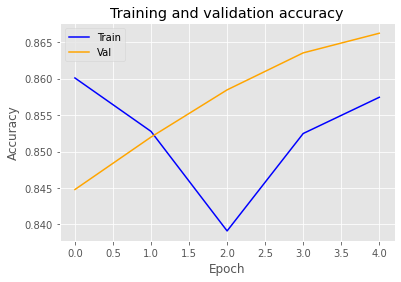

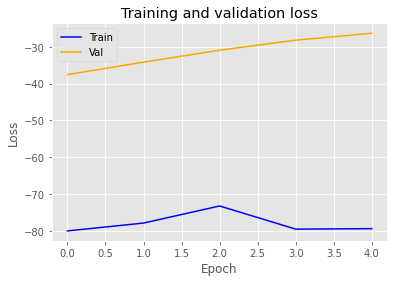

In [ ]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(results)

In [ ]:
# Model trained for approx 45 epochs on level 6
results = model.fit(x_train_Unet, y_train_Unet, batch_size=32, epochs=10, callbacks=callbacks,
                    validation_data=(x_val_Unet, y_val_Unet))

Train on 416 samples, validate on 136 samples
Epoch 1/10
 96/416 [=====>........................] - ETA: 1:02 - loss: -220.6639 - accuracy: 0.6285

In [ ]:
indices = [8, 9, 12]
for index in indices:
  predictions = model.predict(np.array([x_val_Unet[index]]))
  predictions = tf.squeeze(predictions)
  print(predictions.shape)
  plt.imshow(tf.squeeze(x_val_Unet[index]))
  plt.imshow(predictions, cmap='jet', alpha=0.5)
  plt.show()
for index in indices:
  true_label = tf.squeeze(y_val_Unet[index])
  plt.imshow(tf.squeeze(x_val_Unet[index]))
  plt.imshow(true_label, cmap='jet', alpha=0.5)
  plt.show()

In [ ]:
model_path = root_path + "/model_unet_level6_v1.h5"
model.save(model_path)

In [ ]:
plot(results)